# Fermionic Dimer

In [1]:
using Pkg; Pkg.activate()
using KadanoffBaym
using LinearAlgebra

using PyPlot
PyPlot.plt.style.use("./paper.mplstyle")
using LaTeXStrings

  Activating project at `~/.julia/environments/v1.10`


## Model

### Tight-binding Hamiltonian:

\begin{align}\begin{split}
	\hat{H} &= \sum_{i=1}^L \varepsilon_i \hat{c}_i^{\dagger} \hat{c}_i^{\phantom{\dagger}} + J \sum_{\langle i, j\rangle}\left(\hat{c}_i^{\dagger} \hat{c}_j^{\phantom{\dagger}} + \hat{c}_j^{\dagger} \hat{c}_i^{\phantom{\dagger}}\right)
\end{split}\end{align}

### Green functions

\begin{align}\begin{split}
	\left[\boldsymbol{G}^>(t, t')\right]_{ij} &= G^>_{ij}(t, t') = -i\left\langle{\hat{c}_i^{\phantom{\dagger}}(t)\hat{c}_j^{{\dagger}}(t')}\right\rangle \\
	\left[\boldsymbol{G}^<(t, t')\right]_{ij} &= G^<_{ij}(t, t') = \phantom{-} i\left\langle{\hat{c}_j^{{\dagger}}(t')\hat{c}_i^{\phantom{\dagger}}(t)}\right\rangle
\end{split}\end{align}

### Equations of motion

\begin{align}\begin{split}
	i\partial_t \boldsymbol{G}^{\lessgtr}(t, t') &= \boldsymbol{H} \boldsymbol{G}^{\lessgtr}(t, t') \\
	i\partial_T \boldsymbol{G}^{\lessgtr}(T, 0)_W &= [\boldsymbol{H},\boldsymbol{G}^{\lessgtr}(T, 0)_W]
\end{split}\end{align}

\begin{align}\begin{split}
	\boldsymbol{H} &= 
	\begin{pmatrix}
		\varepsilon_1 & J      &        &   \\
		J             & \ddots & \ddots &   \\
		              & \ddots & \ddots & J \\
		              &        & J & \varepsilon_L 
	\end{pmatrix}
\end{split}\end{align}

## Defining the model

In [2]:
# quantum numbers
dim = 2

# Allocate the initial Green functions (time arguments at the end)
GL = GreenFunction(zeros(ComplexF64, dim, dim, 1, 1), SkewHermitian)
GG = GreenFunction(zeros(ComplexF64, dim, dim, 1, 1), SkewHermitian)

# initial condition
N_0 = 1.0
GL[1, 1] = +im * diagm([N_0, 0.0])
GG[1, 1] = -im * I(2) + GL[1, 1];

In [3]:
# Hamiltonian matrix
ε₁ = 1.0/20
ε₂ = -1.0/20
H = ComplexF64[ε₁ 1.0; 1.0 ε₂];

# right-hand side for the "vertical" evolution
function fv!(out, _, _, _, t1, t2)
    out[1] = -1.0im * H * GL[t1, t2]
    out[2] = -1.0im * H * GG[t1, t2]
end

# right-hand side for the "diagonal" evolution
function fd!(out, h1, h2, times, t1, t2)
  fv!(out, times, h1, h2, t1, t2)
  out[1] .-= adjoint(out[1])
  out[2] .-= adjoint(out[2])
end

# Analytic result
ana(i1, i2, t1, t2) = (exp(-1.0im * H * t1) * GL[:, :, 1, 1] * exp(1.0im * H * t2))[i1, i2];

## Solving an example

In [4]:
# call the solver
sol = kbsolve!(fv!, fd!, [GL, GG], (0.0, 100.0); atol=1e-9, rtol=1e-7);

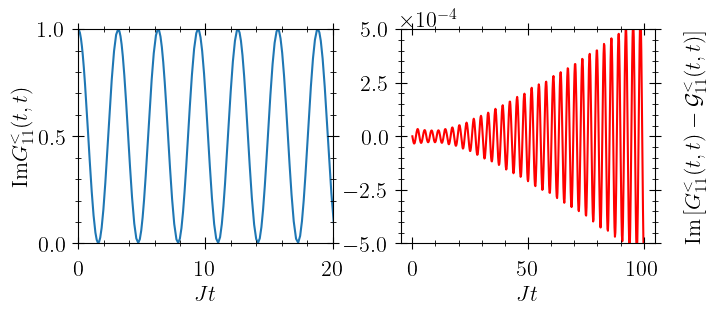

In [5]:
let
    # two quantum numbers to plot
    idx1 = 1
    idx2 = 1;

    xpad = 8
    ypad = 5

    fig = figure(figsize=(7, 3))

    ax = subplot(121)
    plot(sol.t, [imag(GL.data[idx1, idx2, k, k]) for k in 1:length(sol.t)], marker="", ms=3.0, ls="-", c="C0")
    ax.set_xlim(0, 20.)
    ax.set_ylim(0, N_0)
    # ax.set_xticks(J .* [0, 0.5, 1])
    ax.set_yticks([0, 0.5, 1])
    ax.set_xlabel(L"J t")
    ax.set_ylabel(L"\mathrm{Im}G^<_{11}(t, t)")
    ax.xaxis.set_tick_params(pad=xpad)
    ax.yaxis.set_tick_params(pad=ypad)
    ax.set_axisbelow(false)
    ticklabel_format(axis="y", style="sci", scilimits=(-0, 0))

    ax = subplot(122)
    plot(sol.t, [imag(GL.data[idx1, idx2, k, k] - ana(idx1, idx2, sol.t[k], sol.t[k])) for k in eachindex(sol.t)], marker="", ms=3.0, ls="-", c="r")
    # ax.set_xlim(0, J * 5)
    ax.set_ylim((-5, 5) .* 1e-4)
    # ax.set_xticks(J .* [0, 1, 2, 3, 4, 5])
    ax.set_xlabel(L"J t")
    ax.set_ylabel(L"\mathrm{Im}\left[G^<_{11}(t, t) - \mathcal{G}^<_{11}(t, t)\right]", labelpad=16)
    ax.xaxis.set_tick_params(pad=xpad)
    ax.yaxis.set_tick_params(pad=ypad)
    ax.yaxis.set_label_position("right")
    ax.set_axisbelow(false)
    ticklabel_format(axis="y", style="sci", scilimits=(-0, 0))

    tight_layout(pad=0.1, w_pad=0.75, h_pad=0)
    # savefig("fermion_example_1.pdf")
    fig
end;

## Error analysis

In [8]:
using LsqFit

idx1 = 1
idx2 = 1

epsilons = [10^(-k) for k in range(3, 10; length=30)]

err_data = []
p_norm = 1

for (k, eps) in enumerate(epsilons)
    print("$k, ")

    sol = kbsolve!(fv!, fd!, [GL, GG], (0.0, 100.0); dtini=1e-10, atol=1e-2eps, rtol=eps, kmax=9);

    s = [ana(i, j, t1, t2) for i in 1:2, j in 1:2, t1 in sol.t, t2 in sol.t]
    push!(err_data, (length(sol.t), KadanoffBaym.norm(GL.data - s), eps))
end

xdata = log10.([x[1] for x in err_data])
ydata = log10.([x[2] for x in err_data]);

fit_func = (n, p) -> -p[1] .* n .+ p[2];
fit_result = curve_fit(fit_func, xdata, ydata, [2.0, 1]);
coef(fit_result)

1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 

2-element Vector{Float64}:
 10.121800894933633
 24.752799200659698

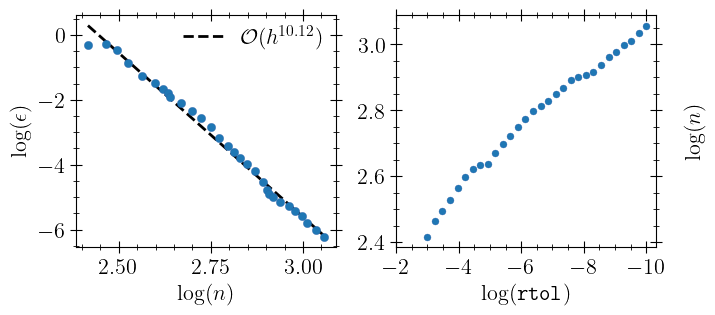

In [9]:
let
    fig = figure(figsize=(7, 3))

    ax = subplot(121)
    plot(xdata, map(x -> fit_func(x, coef(fit_result)), xdata), "--k", lw=2,
         label=L"\mathcal{O}(h^{%$(floor(coef(fit_result)[1], sigdigits=4))})")
    plot(xdata, ydata, "o", lw=0, ms=6,
         markerfacecolor="C0", markeredgewidth=0.25, markeredgecolor="#2D5FAA")
    ax.set_xlabel(L"\log(n)")
    ax.set_ylabel(L"\log(\epsilon)")
    legend(loc="best", handlelength=1.8, frameon=false, borderpad=0, labelspacing=0)

    ax = subplot(122)
    plot(log10.([x[3] for x in err_data]), log10.([x[1] for x in err_data]), "o", ms=5,
         markerfacecolor="C0", markeredgewidth=0.25, markeredgecolor="#2D5FAA")
    ax.set_xlim(-2, -10.3)
    ax.set_xticks([-2, -4, -6, -8, -10])
    ax.yaxis.set_label_position("right")
    ax.set_xlabel(L"\log(\texttt{rtol})")
    ax.set_ylabel(L"\log(n)", labelpad=16)

    tight_layout(pad=0.1, w_pad=0.75, h_pad=0)
    # savefig("fermion_example_error_scaling.pdf")
end

## Comparison with fixed-step scheme

In [10]:
begin
    # short final time
    T = 0.4;

    sol_adaptive = kbsolve!(fv!, fd!, [GL, GG], (0.0, T); 
        dtini=1e-6, rtol=1e-5, atol=1e-12, γ=99/100);
    dts_adaptive = diff(sol_adaptive.t);
    @show size(dts_adaptive)
    @show error = let
      s = [ana(i, j, t1, t2) for i in 1:2, j in 1:2, t1 in sol_adaptive.t, t2 in sol_adaptive.t]
      KadanoffBaym.norm(GL.data - s)
    end


    sol_fixed = kbsolve!(fv!, fd!, [GL, GG], (0.0, T); 
        dtini=1e-6, rtol=1e-5, dtmax=1e-2, atol=1e-12, γ=9999/10000)
    dts_fixed = diff(sol_fixed.t);
    @show size(dts_fixed)
    @show error = let
      s = [ana(i, j, t1, t2) for i in 1:2, j in 1:2, t1 in sol_fixed.t, t2 in sol_fixed.t]
      KadanoffBaym.norm(GL.data - s)
    end;

    sol_fixed2 = kbsolve!(fv!, fd!, [GL, GG], (0.0, T); 
        dtini=1e-2, rtol=1e0, dtmax=1e-2, atol=1e-12, γ=1)
    dts_fixed2 = diff(sol_fixed2.t);
    @show size(dts_fixed2)
    @show error = let
      s = [ana(i, j, t1, t2) for i in 1:2, j in 1:2, t1 in sol_fixed2.t, t2 in sol_fixed2.t]
      KadanoffBaym.norm(GL.data - s)
    end;
end

size(dts_adaptive) = (16,)
error = let
        #= In[10]:10 =#
        s = [ana(i, j, t1, t2) for i = 1:2, j = 1:2, t1 = sol_adaptive.t, t2 = sol_adaptive.t]
        #= In[10]:11 =#
        KadanoffBaym.norm(GL.data - s)
    end = 6.923179190866946e-7
size(dts_fixed) = (50,)
error = let
        #= In[10]:20 =#
        s = [ana(i, j, t1, t2) for i = 1:2, j = 1:2, t1 = sol_fixed.t, t2 = sol_fixed.t]
        #= In[10]:21 =#
        KadanoffBaym.norm(GL.data - s)
    end = 7.001315214176808e-7
size(dts_fixed2) = (40,)
error = let
        #= In[10]:29 =#
        s = [ana(i, j, t1, t2) for i = 1:2, j = 1:2, t1 = sol_fixed2.t, t2 = sol_fixed2.t]
        #= In[10]:30 =#
        KadanoffBaym.norm(GL.data - s)
    end = 0.0069857560073314515


0.0069857560073314515

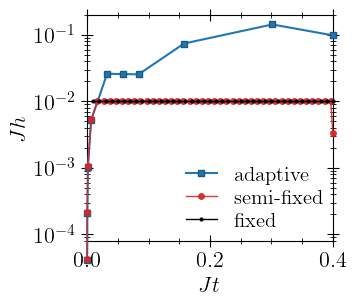

In [11]:
let
    fig = figure(figsize=(3.5, 3))
    ax = fig.add_subplot(111)

    ax.tick_params(axis="y", which="minor")
    ax.set_xlim(0, T)
    ax.set_ylim(8e-5, 2e-1)

    n = 7

    # we discard the points that are outside of ylim (since we are drawing on top of the canvas)
    ax.semilogy(sol_adaptive.t[n+1:end], dts_adaptive[n:end], "s-C0", lw=1.5, ms=5, label="adaptive", markeredgecolor="#22577c", clip_on=false, zorder=100)
    ax.semilogy(sol_fixed.t[n+1:end], dts_fixed[n:end], "o-C3", lw=1, ms=4, label="semi-fixed", alpha=0.9, clip_on=false, zorder=100)
    ax.semilogy(sol_fixed2.t[2:end], dts_fixed2, "o-k", lw=1, ms=2, label="fixed", clip_on=false, zorder=100)

    xlabel(L"J t")
    ylabel(L"J h")
    legend(loc="lower right", frameon=false, labelspacing=0.2, borderpad=0.0, handlelength=1.5, fontsize=15)

    locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=10)
    ax.yaxis.set_minor_locator(locmin)
    ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

    tight_layout(pad=0.3)
    # savefig("fermion_example_adaptive_dt.pdf")
    fig
end;